# Authorship Attribution

From Chapter 5 of Getting Started with Natural Language Processing (2022, Kochmar)

The goal of this notebook is to train and evaluate a machine learning algorithm to classify a sentence as written by one of two authors (classification).

# 1. Preliminary Steps

In [23]:
# imports
import nltk
from nltk.corpus import gutenberg # data for training
import random
import sklearn
from sklearn.model_selection import StratifiedShuffleSplit
from nltk import NaiveBayesClassifier, classify, DecisionTreeClassifier
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

# # if first time running, may also need:
# nltk.download('punkt') # sentence tokenizer
# nltk.download('gutenberg')

In [2]:
# select data for training

gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [3]:
# shakespeare and austen each have three attributed works, so we will use
# them as our data

# will use 2 works from each author as training and pretest data; third work
# will be reserved for testing data

# create training and testing data sentences for author1 (austen)
author1_train = gutenberg.sents('austen-emma.txt') + \
                gutenberg.sents('austen-persuasion.txt')
author1_test = gutenberg.sents('austen-sense.txt')

# create training and testing data sentences for author1 (shakespeare)
author2_train = gutenberg.sents('shakespeare-caesar.txt') + \
                gutenberg.sents('shakespeare-hamlet.txt')
author2_test = gutenberg.sents('shakespeare-macbeth.txt')

# check length of data sets
print(f"Author 1 training set length: {len(author1_train)} sentences")
print(f"Author 1 testing set length: {len(author1_test)} sentences")
print(f"Author 2 training set length: {len(author2_train)} sentences")
print(f"Author 2 testing set length: {len(author2_test)} sentences")

Author 1 training set length: 11464 sentences
Author 1 testing set length: 4999 sentences
Author 2 training set length: 5269 sentences
Author 2 testing set length: 1907 sentences


# 2. Statistics comparing authors

In [4]:
# define helper function to calculate statistics
def statistics(gutenberg_data):
    
    # iterate over works given
    for work in gutenberg_data:
        
        # number of characters in a work
        num_chars = len(gutenberg.raw(work))
        
        # number of words in a work
        num_words = len(gutenberg.words(work))
        
        # number of sentences in a work
        num_sents = len(gutenberg.sents(work))
        
        # number of unique words in a work (python set over list of all words)
        num_vocab = len(set(w.lower() for w in gutenberg.words(work)))
        
        print(
            # average length of words
            round(num_chars/num_words),
            
            # average length of sentences
            round(num_words/num_sents),
            
            # average number of times each word is used in a text by the author
            round(num_words/num_vocab),
            
            # name of work
            work
        )

In [5]:
# make list of works to get statistics for
gutenberg_data = ['austen-emma.txt', 'austen-persuasion.txt', 
                  'austen-sense.txt', 'shakespeare-caesar.txt', 
                  'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt']

In [6]:
# run statistics function on list of works
statistics(gutenberg_data)

5 25 26 austen-emma.txt
5 26 17 austen-persuasion.txt
5 28 22 austen-sense.txt
4 12 9 shakespeare-caesar.txt
4 12 8 shakespeare-hamlet.txt
4 12 7 shakespeare-macbeth.txt


Austen on average uses slightly longer words than Shakespeare (an average of 5 letters to 4). She also uses much longer sentences (an average of 25-28 words, depending on the text, to 12). Perhaps influenced by the length of her works, the average number of times a single word is used across a whole text by Austen ranges from 17-26, while Shakespeare's words only get repeated an average of 7-9 times.

# 3. Split data into training and pretesting sets

In [7]:
# add all sentences in training set to list, keeping author label
all_sents = [(sent, "austen") for sent in author1_train]
all_sents += [(sent, "shakespeare") for sent in author2_train]

# check number of sentences in all_sents
print(f"Training set length: {str(len(all_sents))} sentences")

Training set length: 16733 sentences


In [8]:
# keep set of labels (authors) as values
values = [author for (sent, author) in all_sents]

# instantiate stratified shuffle split
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

# create empty lists for train and pretest sets
strat_train_set = []
strat_pretest_set = []

# perform split
for train_index, pretest_index in split.split(all_sents, values):
    strat_train_set = [all_sents[index] for index in train_index]
    strat_pretest_set = [all_sents[index] for index in pretest_index]

In [9]:
# set test_set data to same structure as strat_train_set and strat_pretest_set
test_set = [(sent, "austen") for sent in author1_test]
test_set += [(sent, "shakespeare") for sent in author2_test]

In [10]:
# check the proportions of the data in sets: 
# overall (strat_train and strat_pretest), strat_train_set, strat_pretest_set, and test_set

# define helper function to calculate proportions
def cat_proportions(data, cat):
    
    # initialize count of sentences
    count = 0
    
    # iterate over sentences in data
    for item in data:
        
        # if the item's author is cat
        if item[1] == cat:
            
            # increment count
            count += 1
    
    # return proportion
    return float(count) / float(len(data))

# set authors as categories
categories = ["austen", "shakespeare"]

# create rows for table
rows = []
rows.append(["Category", "(strat_train_set and strat_pretest_set)", 
             "strat_train_set", "strat_pretest_set", "test_set"])

# populate list for rows
for cat in categories:
    rows.append([cat, 
                 f"{cat_proportions(all_sents, cat): .6f}",
                 f"{cat_proportions(strat_train_set, cat): .6f}",
                 f"{cat_proportions(strat_pretest_set, cat): .6f}",
                 f"{cat_proportions(test_set, cat): .6f}"])

# make table, adjust column widths, and populate rows
columns = zip(*rows)
column_widths = [max(len(item) for item in col) for col in columns]
for row in rows:
    print(''.join(' {:{width}} '.format(row[i], width = column_widths[i])
                 for i in range(0, len(row))))

 Category     (strat_train_set and strat_pretest_set)  strat_train_set  strat_pretest_set  test_set  
 austen        0.685113                                 0.685119         0.685091           0.723863 
 shakespeare   0.314887                                 0.314881         0.314909           0.276137 


# 4. Extract words as features

In [11]:
# create function
def get_features(text):
    
    # create empty dictionary
    features = {}
    
    # create word list from text
    word_list = [word for word in text]
    
    # iterate over word_list
    for word in word_list:
        
        # set a presence flag to "True" in dictionary
        features[word] = True
    
    # return dictionary of features
    return features

# get feature dictionary for strat_train_set and strat_pretest_set
train_features = [(get_features(sents), label) for (sents, label) in strat_train_set]
pretest_features = [(get_features(sents), label) for (sents, label) in strat_pretest_set]

# checks
print(len(train_features))
print(len(pretest_features))

13386
3347


# 5. Naive Bayes

## 5.1 Train NB classifier and evaluate on training data

In [12]:
# show size of training data set
print(f"Training set size: {str(len(train_features))} sentences")

# train classifier on training features
classifier = NaiveBayesClassifier.train(train_features)

# print accuracy on training data set
print(f"Accuracy on the training set: {str(classify.accuracy(classifier, train_features))}")

Training set size: 13386 sentences
Accuracy on the training set: 0.9783355744808009


In [13]:
# show most informative features
classifier.show_most_informative_features(50)

Most Informative Features
                    King = True           shakes : austen =    202.3 : 1.0
                    thou = True           shakes : austen =    192.2 : 1.0
                    been = True           austen : shakes =    154.5 : 1.0
                    only = True           austen : shakes =    125.2 : 1.0
                     own = True           austen : shakes =    105.6 : 1.0
                       d = True           shakes : austen =     65.2 : 1.0
                    doth = True           shakes : austen =     60.2 : 1.0
                   quite = True           austen : shakes =     52.1 : 1.0
                     Tis = True           shakes : austen =     50.0 : 1.0
                    Lord = True           shakes : austen =     48.9 : 1.0
                   think = True           austen : shakes =     41.5 : 1.0
                     She = True           austen : shakes =     38.2 : 1.0
                     few = True           austen : shakes =     36.0 : 1.0

## 5.2 Evaluate on Pretest Data

In [14]:
# show size of pretest data set
print(f"Pretest set size: {str(len(pretest_features))} sentences")

# print accuracy on training data set
print(f"Accuracy on the pretest set: {str(classify.accuracy(classifier, pretest_features))}")

Pretest set size: 3347 sentences
Accuracy on the pretest set: 0.9611592470869436


## 5.3 Evaluate on Test Data

In [15]:
# get features from test set data
test_features = [(get_features(sents), label) for (sents, label) in test_set]

# show size of test data set
print(f"Test set size: {str(len(test_features))}")

# print accuracy on the test set (which consists of a different literary work for each author)
print(f"Accuracy on the test set: {str(classify.accuracy(classifier, test_features))}")

Test set size: 6906
Accuracy on the test set: 0.8964668404286128


Accuracy of the classifier on the training and pretest data is relatively comparable (about 0.98 to 0.96). Both these data sets consist of sentences from two works from each author. 

The accuracy of the classifier on the test data drops significantly (to about 0.90). The test set consists of sentences from one new work from each author that was not included in the training and test sets. This indicates that the classifier is overfitting on the training data.

# 6. Decision Tree

## 6.1 Feature Selection

In [16]:
# select middle range of features to run DT on
# this will speed up the algorithm (13,553 features without selection)
# words that occur across most texts are not informative, since they are used by both authors
# words that occur very infreqently, even if they clearly indicate one authorship, will probably not be seen in the test data

# create empty list to store words
words = []

# define helper function that will return the set of all words in a text
def extract_words(text, words):
    
    # add to words list: the set of every word in the text
    words += set([word for word in text])
    
    # return words list
    return words

In [17]:
# iterate over strat_train_set
for (sents, label) in strat_train_set:
    
    # run helper function extract_words
    words = extract_words(sents, words)

In [18]:
# count words with Counter; this calculates document frequency for each word in training set
counts = Counter(words)

# check
print(counts)

Counter({'.': 9090, ',': 7147, 'to': 4356, 'the': 4106, 'and': 3996, 'of': 3812, 'a': 3054, 'I': 2959, 'in': 2442, 'not': 2411, ';': 2389, 'was': 2290, 'it': 2219, 'be': 2131, 'that': 1958, '"': 1913, 'her': 1891, 'you': 1889, "'": 1723, 'had': 1608, 'for': 1533, 'with': 1508, 'is': 1484, 'she': 1472, 'but': 1417, 'he': 1376, 'as': 1353, 'have': 1315, '."': 1235, 'his': 1232, 'at': 1166, 'very': 1153, 's': 1110, 'all': 1080, 'him': 1049, 'Mr': 1028, 'so': 1027, 'my': 981, 'could': 935, 'on': 887, 'would': 879, '?': 855, ':': 844, 'been': 842, 'me': 838, '--': 833, 'no': 783, 'by': 777, 'were': 761, 'this': 734, 'Mrs': 725, 'which': 715, 'She': 713, 'do': 713, 'will': 701, '-': 686, '!': 682, 'Emma': 681, 'from': 671, 'must': 664, 'any': 638, 'more': 618, 'The': 618, 'He': 603, 'are': 599, 'what': 596, 'them': 595, 'or': 585, 'they': 576, 'an': 574, 'much': 573, 'And': 552, 'your': 552, 'there': 544, 'said': 541, 'It': 535, 'Miss': 527, ',"': 523, 'good': 507, 'one': 506, 'such': 502, '

In [19]:
# visualize word document frequencies to show many words are too frequent or too infrequent to be informative
# (Zipf's law)

df = pd.DataFrame.from_dict(counts, orient='index').reset_index()
df.rename(columns = {0: 'occurrences'}, inplace = True)

# check
df.head()

,index,occurrences
0,Why,95
1,you,1889
2,?,855
3,aske,4
4,this,734


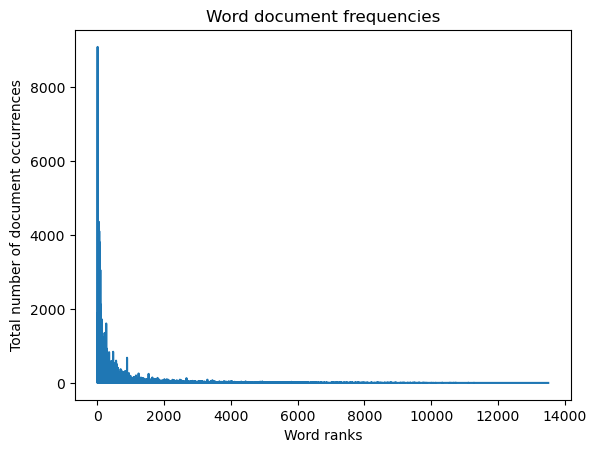

In [21]:
# plot frequencies
plt.plot(df['occurrences'])
plt.xlabel("Word ranks")
plt.ylabel("Total number of document occurrences")
plt.title("Word document frequencies");

In [24]:
# get selected features for DT classifier

# max number of sentences in which a word may occur is 13,414
maximum = float(13414)

# create empty list to store selected words (features)
selected_words = []

# select only words that occur in:
# 1. more than 200 sentences, and
# 2. less than 20% of sentences (2,683)

# iterate over counts' items
for item in counts.items():
    
    # assign float of number of occurrences to count
    count = float(item[1])
    
    # set thresholds
    if count > 200 and count / maximum < 0.2:
        
        # append word to selected_words list
        selected_words.append(item[0])

# check
print(len(selected_words))

165


In [25]:
# define helper function to extract features from sentences only using words from selected_words
def get_features(text, selected_words):
    features = {}
    word_list = [word for word in text]
    for word in word_list:
        if word in selected_words:
            features[word] = True
    return features

In [28]:
# set features for training, pretest, and testing set

train_features2 = [(get_features(sents, selected_words), label)
                 for (sents, label)
                 in strat_train_set]

pretest_features2 = [(get_features(sents, selected_words), label)
                 for (sents, label)
                 in strat_pretest_set]

test_features2 = [(get_features(sents, selected_words), label)
                 for (sents, label)
                 in test_set]

## 6.2 Train DT classifier and evaluate on training data

In [29]:
# train DT classifier on training data only
dt_classifier = DecisionTreeClassifier.train(train_features2)

In [30]:
# show size of training data set
print(f"DT Training set size: {str(len(train_features2))} sentences")

# print accuracy on training data set
print(f"DT Accuracy on the training set: {str(classify.accuracy(dt_classifier, train_features2))}")

DT Training set size: 13386 sentences
DT Accuracy on the training set: 0.8097265800089646


## 6.3 Evaluate DT on Pretest Data

In [33]:
# show size of pretest data set
print(f"DT Pretest set size: {str(len(pretest_features2))} sentences")

# print accuracy on pretest data set
print(f"DT Accuracy on the pretest set: {str(classify.accuracy(dt_classifier, pretest_features2))}")

DT Pretest set size: 3347 sentences
DT Accuracy on the pretest set: 0.7905587092919032


## 6.4 Evaluate DT on Test Data

In [34]:
# show size of test data set
print(f"DT Test set size: {str(len(test_features2))}")

# print accuracy on the test set (which consists of a different literary work for each author)
print(f"DT Accuracy on the test set: {str(classify.accuracy(dt_classifier, test_features2))}")

DT Test set size: 6906
DT Accuracy on the test set: 0.8092962641181581


Accuracy of the Decision Tree Classifier on all three data sets (training, pretest, and testing) is relatively comparable (about 0.81 to 0.79 to 0.81). This indicates that the model is truly learning, and is not overfitting like the Naive Bayes Classifier. It is more generalizable to new data.

The Decision Tree Classifier has also been trained on many fewer features (166 vs. 13,553). 